In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import imageio
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.compat.v1.enable_eager_execution()

In [102]:
def LoadData(data_path, json_name, width, height, params = None):
    with open(os.path.join(data_path, json_name), 'r') as json_file:
        data = json.load(json_file)
        
        images = []
        poses = []
    
        for frame in data['frames']:
            img_path = os.path.join(data_path, frame['file_path'] + '.png')
            images.append(imageio.imread(img_path))
            poses.append(np.array(frame['transform_matrix']))
        images = (np.array(images) / 255.).astype(np.float32)
        poses = np.array(poses).astype(np.float32)
    
        images = tf.compat.v1.image.resize_area(images, [height, width]).numpy()
        camera_angle_x = float(train_data['camera_angle_x'])
        
        if params is not None:
            params['focal_length'] = .5 * width / np.tan(.5 * camera_angle_x)
        
    return images, poses 
    
def PositionEncoder(x, L):
    encoded_x = [x]
    for i in range(L):
        for func in [tf.sin, tf.cos]:
            encoded_x.append(func(2.0 ** i * x))
    return tf.concat(encoded_x, axis = -1)

def GenerateRays(width, height, focal_length, trans_mat):  
    # Generate rays in camera frame.
    i, j = tf.meshgrid(\
        tf.range(width, dtype = tf.float32),\
        tf.range(height, dtype = tf.float32),\
        indexing = 'xy'\
    )
    
    # The depth from pinhole to camera plane is 1.
    ray_cam = tf.stack(\
        [\
            (-0.5 * width + i) / focal_length,\
            (0.5 * height - j) / focal_length,\
            -tf.ones_like(i)\
        ],\
        axis = -1\
    )
    
    # Transfer the rays from camera frame to world frame.
    ray_dir = tf.reduce_sum(ray_cam[..., None, :] * trans_mat[:3, :3], axis = -1)
    ray_ori = tf.broadcast_to(trans_mat[:3, -1], tf.shape(ray_dir))
    
    return ray_ori, ray_dir

def GetPdfFromWeights(weights, bins, n_samples):
    # Get pdf
    weights += 1e-5
    pdf = weights / tf.reduce_sum(weights, -1, keepdims=True)
    cdf = tf.cumsum(pdf, -1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], -1)

    # Take uniform samples
    u = tf.random.uniform(list(cdf.shape[:-1]) + [n_samples])

    # Invert CDF
    inds = tf.searchsorted(cdf, u, side='right')
    below = tf.maximum(0, inds-1)
    above = tf.minimum(cdf.shape[-1]-1, inds)
    inds_g = tf.stack([below, above], -1)
    cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)

    denom = (cdf_g[..., 1]-cdf_g[..., 0])
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u-cdf_g[..., 0])/denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1]-bins_g[..., 0])

    return samples

def VolumeRender(ray_dir, z_vals, outputs):
    # rendering equation:
    #   res = sum^N_{i = 1} T_i x density_i x color_i
    #   T_i = exp(-sum^i_{j=1} -alpha_j x t_j)
    #   density_i = 1 - exp(-alpha_i x t_i)
    
    # Generate t_i
    t = z_vals[..., 1:] - z_vals[..., :-1]
    # The last time piece is infity.
    t = tf.concat([t, tf.broadcast_to([1e10], t[...,:1].shape)], axis = -1)
    # Scale the time with the norm of each ray direction.
    t = t * tf.linalg.norm(ray_dir[..., None, :], axis = -1)
    
    # Get color_i from outputs (map outputs[..., :3] in 0 to 1).
    rgb = tf.math.sigmoid(outputs[..., :3])
    
    # Get alpha_i
    alpha = tf.nn.relu(outputs[..., 3])
    
    # Estimate density_i.
    density = 1.0 - tf.exp(-alpha * t)
    
    # Estimate T_i
    T = tf.math.cumprod(1.0 - density +  1e-10, axis = -1, exclusive = True)
    
    # Get weight_i = T_i x density_i
    weight = density * T
    
    # Weighted sum along each ray.
    res = tf.reduce_sum(weight[..., None] * rgb, axis = -2)
    
    return res, weight
    
def BuildNeRF(n_pos, n_dir, n_layers = 8, n_neurons = 256):
    
    # Seperate the inputs into position and direction.
    inputs = tf.keras.Input(shape=(n_pos + n_dir))
    inputs_pos, inputs_dir = tf.split(inputs, [n_pos, n_dir], axis = -1)
    inputs_pos.set_shape([None, n_pos])
    inputs_dir.set_shape([None, n_dir])
    
    # Construct the Network.
    # 1. Build n_layers MLP with ReLU as activation layer.
    ReLU = tf.keras.layers.ReLU()
    MLP = lambda input_features, W, act :\
        tf.keras.layers.Dense(\
            W, activation = act\
        )(input_features)

    outputs = inputs_pos
    for i_layer in range(n_layers):
        outputs = MLP(outputs, n_neurons, ReLU)
        # Concatenate the input position to output features after the middle layer
        if i_layer == n_layers // 2:
            outputs = tf.concat([inputs_pos, outputs], axis = -1)
            
    # 2. Generate alpha and input features for direction.
    alpha = MLP(outputs, 1, None)
    bottleneck = MLP(outputs, n_neurons, None)
    
    # 3. Concatenate the input views with output features to generate final results
    outputs = tf.concat([bottleneck, inputs_dir], axis = -1)
    outputs = MLP(outputs, n_neurons // 2, ReLU)
    outputs = MLP(outputs, 3, None)
    outputs = tf.concat([outputs, alpha], axis = -1)
    
    return tf.keras.Model(inputs = inputs, outputs = outputs)

def RenderPoints(pos, view_dir, params):
    pos_flat = tf.reshape(pos, [-1, pos.shape[-1]])
    dirs = tf.broadcast_to(view_dir[:, None], pos.shape)
    dirs_flat = tf.reshape(dirs, [-1, dirs.shape[-1]])
        
    inputs = None
    if params['use_encoder']:
        pos_encoder = params['pos_encoder']
        dir_encoder = params['dir_encoder']
        inputs = tf.concat([pos_encoder(pos_flat), dir_encoder(dirs_flat)], axis = -1)
    else:
        inputs = tf.concat([pos_flat, dirs_flat], axis = -1)
        
    batch_size = params['point_batch_size']
    outputs = []
    nerf = params['nerf']
    for i in range(0, pos_flat.shape[0], batch_size):
        outputs.append(nerf(inputs[i:i+batch_size]))
        
    outputs = tf.concat(outputs, axis = 0)
    outputs = tf.reshape(outputs, list(pos.shape[:-1]) + [outputs.shape[-1]])
    return outputs

def RenderRays(rays, params):
    n_rays = rays.shape[0]
    
    ray_ori, ray_dir, view_dir = rays[:, :3], rays[:, 3:6], rays[:, -3:]
    
    bounds = tf.reshape(rays[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1] 
    
    # Estimate the sampling time
    n_samples = params['n_samples']
    t = tf.linspace(0., 1., n_samples)
    z_vals = near * (1 - t) + far * t
    z_vals = tf.broadcast_to(z_vals, [n_rays, n_samples])
    
    # Pertub sampling time
    mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
    upper = tf.concat([mids, z_vals[..., -1:]], -1)
    lower = tf.concat([z_vals[..., :1], mids], -1)
    
    t_rand = tf.random.uniform(z_vals.shape)
    z_vals = lower + (upper - lower) * t_rand
    
    pos = ray_ori[..., None, :] + ray_dir[..., None, :] * z_vals[..., :, None]
    
    # Render Points
    outputs = RenderPoints(pos, view_dir, params)
    res, weight = VolumeRender(ray_dir, z_vals, outputs)
    
    # Resampling according to the rendered results
    if params['importance_sampling']:
        res_0, weight_0 = res, weight

        # Obtain additional integration times to evaluate based on the weights
        # assigned to colors in the coarse model.
        z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = GetPdfFromWeights(
            weight[..., 1:-1], z_vals_mid, n_samples)
        z_samples = tf.stop_gradient(z_samples)

        # Obtain all points to evaluate color, density at.
        z_vals = tf.sort(tf.concat([z_vals, z_samples], -1), -1)
        pos = ray_ori[..., None, :] + ray_dir[..., None, :] * z_vals[..., :, None]

        # Run network with new samples.
        outputs = RenderPoints(pos, view_dir, params)
        res, _ = VolumeRender(ray_dir, z_vals, outputs)
    
    return res

def RenderImage(width, height, pose, params):
    focal_length = params['focal_length']
    
    # Get rays from current camera settings.
    ray_ori, ray_dir = GenerateRays(width, height, focal_length, pose)
    
    # Get normalized view ray directions.
    view_dir = ray_dir
    view_dir = ray_dir / tf.linalg.norm(ray_dir, axis = -1, keepdims = True)
    
    # Flat the input
    ray_ori = tf.cast(tf.reshape(ray_ori, [-1, 3]), dtype = tf.float32)
    ray_dir = tf.cast(tf.reshape(ray_dir, [-1, 3]), dtype = tf.float32)
    view_dir = tf.cast(tf.reshape(view_dir, [-1, 3]), dtype = tf.float32)
    
    near = params['near'] * tf.ones_like(ray_dir[..., :1])
    far = params['far'] * tf.ones_like(ray_dir[..., :1])
    
    rays = tf.concat([ray_ori, ray_dir, near, far, view_dir], axis = -1)
    
    batch_size = params['ray_batch_size']
    render_results = []
    for i in range(0, rays.shape[0], batch_size):
        render_results.append(\
            RenderRays(rays[i:i+batch_size], params)\
        )
    return tf.reshape(tf.concat(render_results, axis = 0), [height, width, 3])

def TrainNeRF(train_images, train_poses,test_image, test_pose, n_epochs, params):
    nerf = params['nerf']

    l_rate = params['learning_rate']
    optimizer = tf.keras.optimizers.Adam(l_rate)
    
    height, width = train_images[0].shape[:2]
    print("----------------Start Training----------------")
    print("W:{0}, H:{1}".format(width, height))
    for k in params:
        if type(params[k]) in {int, str, bool}:
            print('{0}: {1}'.format(k, params[k]))
    
    test_iternum = []
    test_losses = []
    test_psnrs = []
    for i in range(n_epochs):
        # Random select an image to train the model.
        img_i = np.random.randint(train_images.shape[0])
        train_image = train_images[img_i]
        train_pose = train_poses[img_i]
        with tf.GradientTape() as tape:
            predict = RenderImage(width, height, train_pose, params)
            loss = tf.reduce_mean(tf.square(predict - train_image[...,:-1]))
        gradients = tape.gradient(loss, nerf.trainable_variables)
        optimizer.apply_gradients(zip(gradients, nerf.trainable_variables))
        print('-----------------epoch: {0} training loss: {1}------------'.format(i, loss), end = '\r')
        
        if i % 25 == 0 and i > 0:
            test_predict = RenderImage(width, height, test_pose, params)
            test_loss = tf.reduce_mean(tf.square(test_predict - test_image[...,:-1]))
            test_psnr = -10. * tf.math.log(test_loss) / tf.math.log(10.)
            
            test_losses.append(test_loss)
            test_psnrs.append(test_psnr)
            test_iternum.append(i)
            
            plt.figure(figsize=(15,4))
            plt.subplot(131)
            plt.imshow(test_image)
            plt.title(f'GT')
            plt.subplot(132)
            plt.imshow(test_predict)
            plt.title(f'Iteration: {i}')
            plt.subplot(133)
            plt.plot(test_iternum, test_psnrs)
            plt.title('PNSR')
            plt.show()
    return test_losses, test_psnrs

----------------Start Training----------------
W:50, H:50
use_encoder: True
ray_batch_size: 1024
point_batch_size: 1024
n_samples: 64
importance_sampling: False


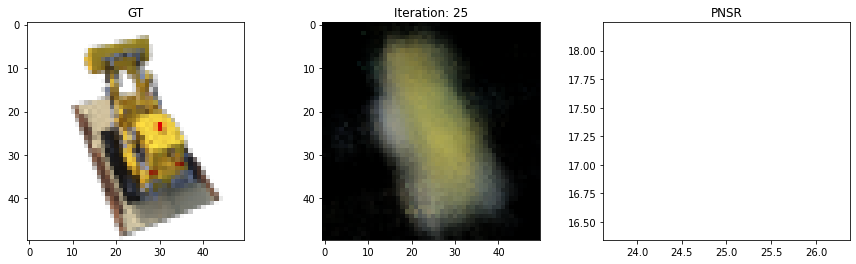

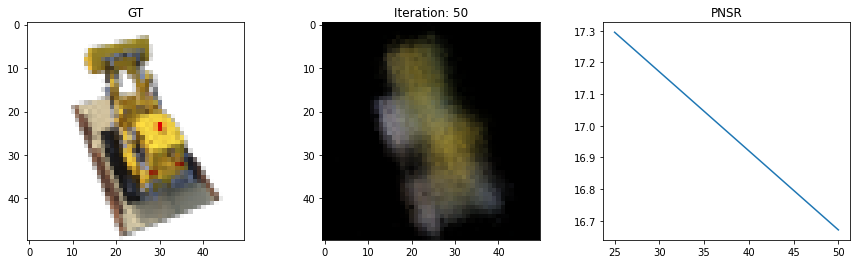

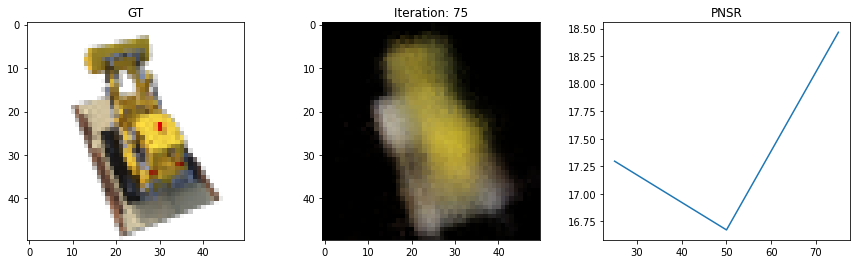

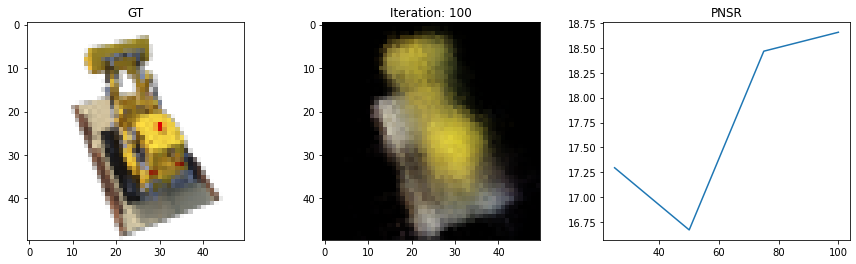

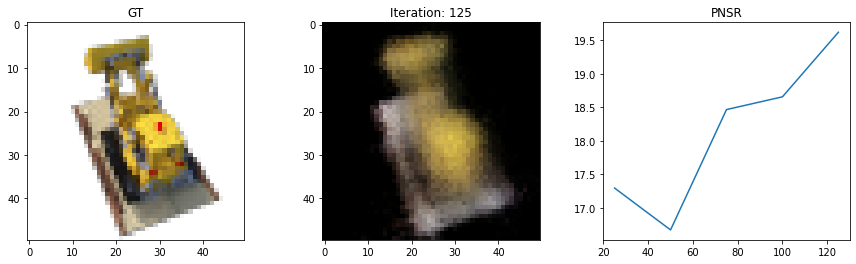

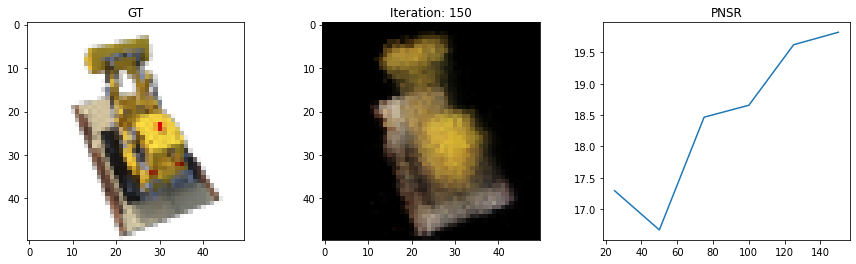

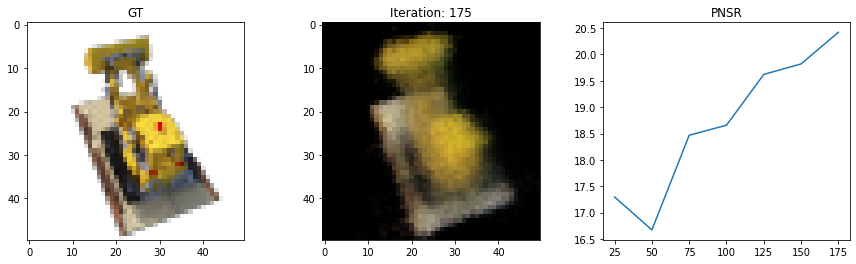

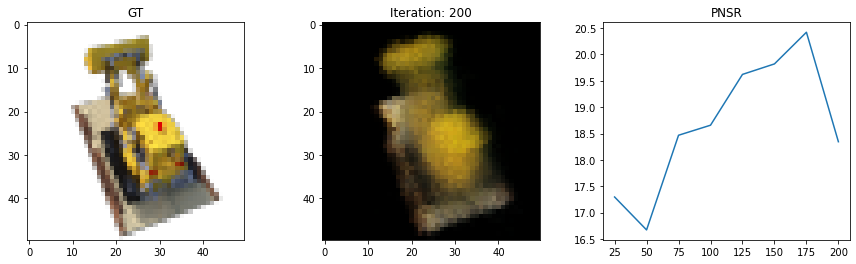

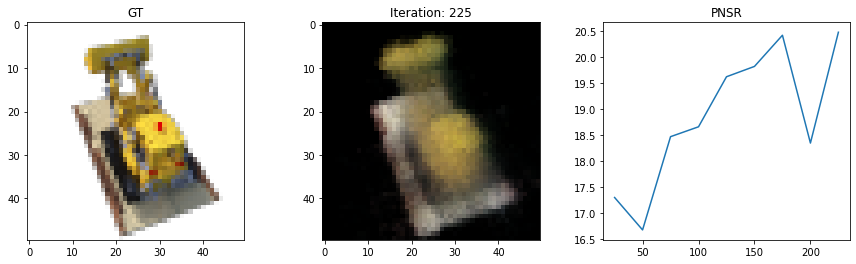

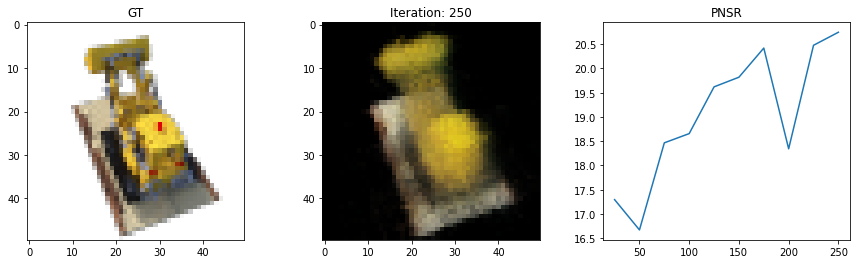

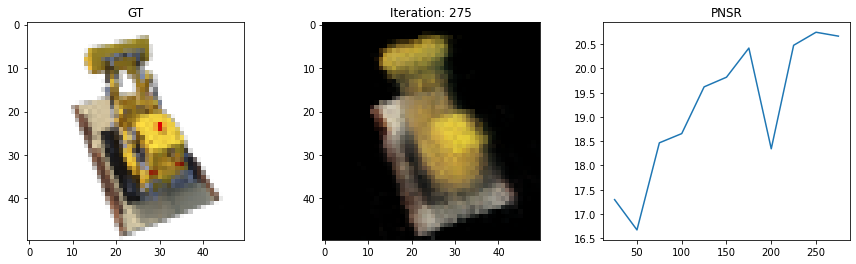

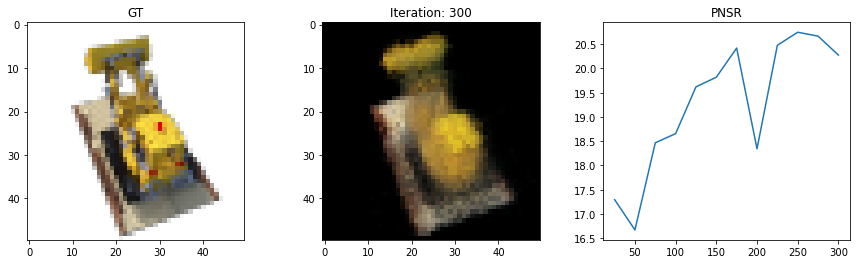

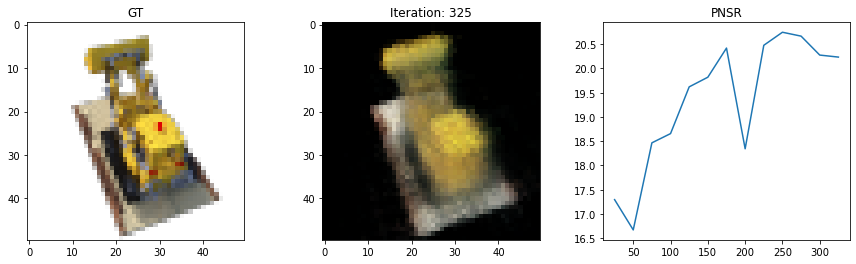

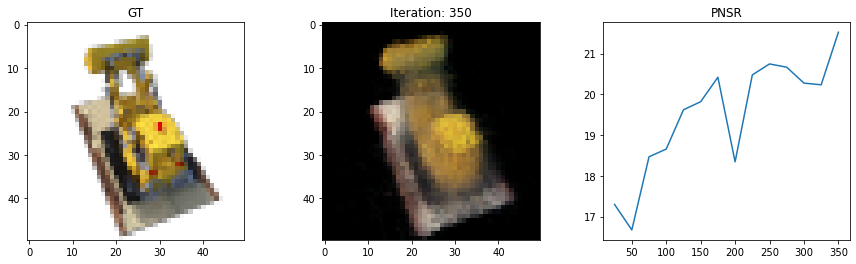

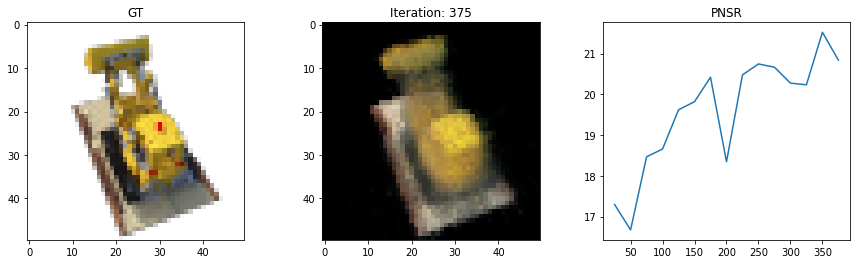

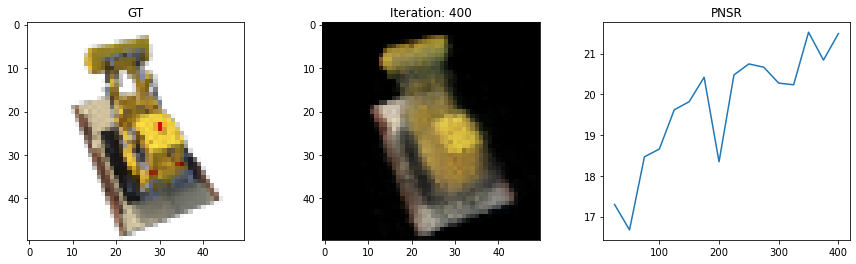

In [ ]:
#params = {}
#params['nerf'] = BuildNeRF(63, 27)
#params['nerf'] = BuildNeRF(3, 3)
params['use_encoder'] = True
params['ray_batch_size'] = 1024
params['point_batch_size'] = 1024
params['near'] = 2.0
params['far'] = 6.0
params['n_samples'] = 64
params['pos_encoder'] = lambda x : PositionEncoder(x, 10)
params['dir_encoder'] = lambda x : PositionEncoder(x, 4)
params['importance_sampling'] = False
params['learning_rate'] = 5e-4

data_path = './data/lego/'

width, height = 50, 50

train_images, train_poses = LoadData(data_path, 'transforms_train.json', width, height, params)
test_images, test_poses = LoadData(data_path, 'transforms_test.json', width, height)

test_id = np.random.randint(test_images.shape[0])
test_image, test_pose = test_images[test_id], test_poses[test_id]

test_losses, test_psnrs = TrainNeRF(\
    train_images, train_poses, test_image, test_pose, 500, params)

## NeRF Graph

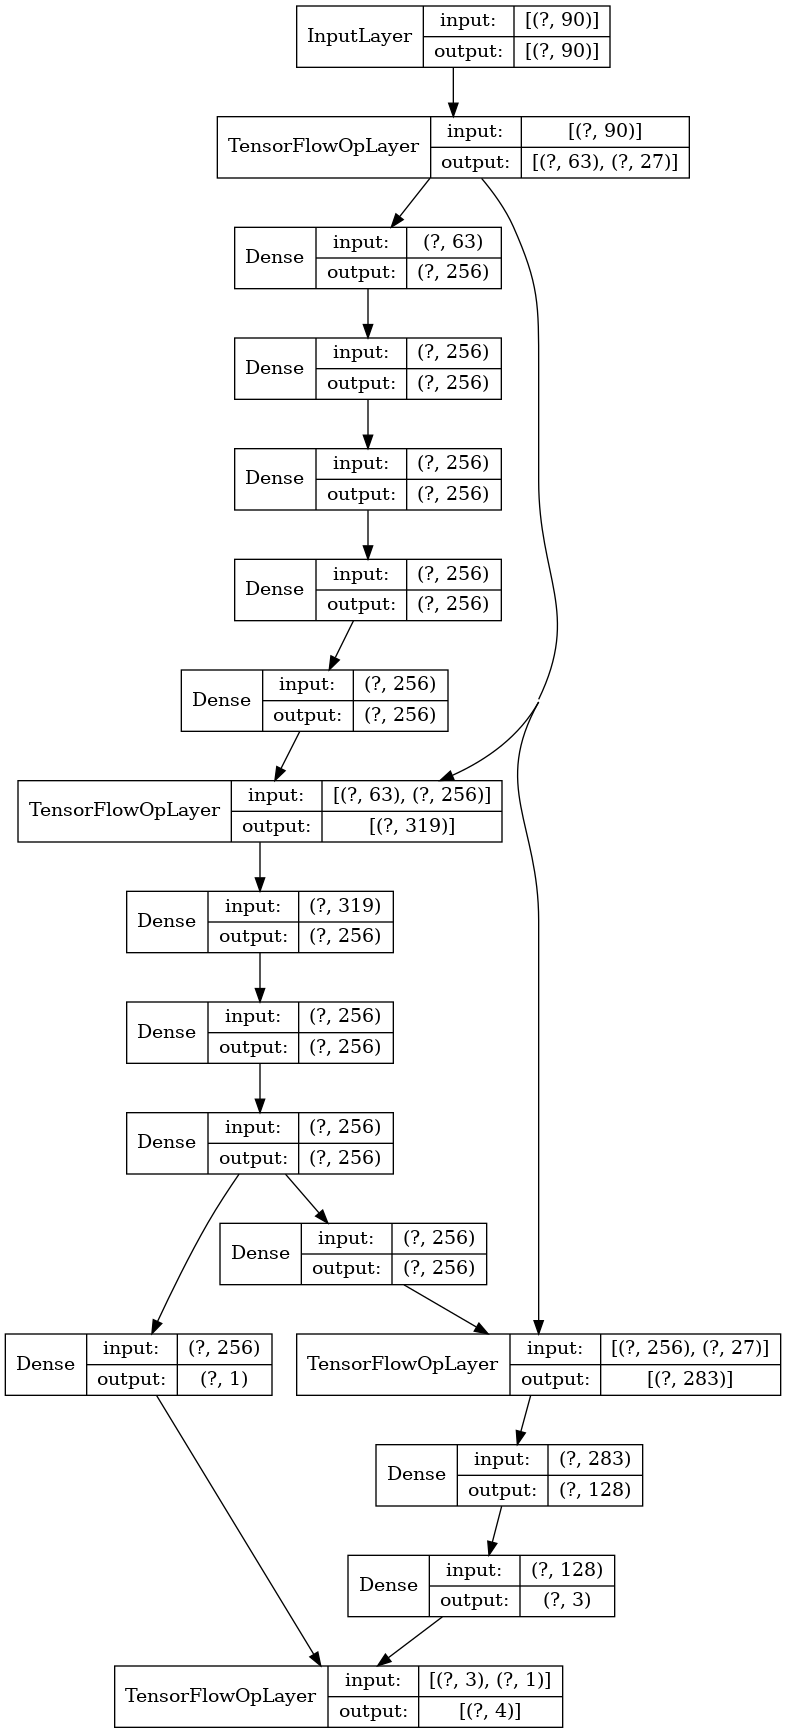

In [106]:
dot_img_file = './nerf_graph.png'
tf.keras.utils.plot_model(params['nerf'], to_file=dot_img_file, show_shapes=True, show_layer_names = False)

In [ ]:
test_predicts = [\
        RenderImage(width, height, test_poses[j], params) for j in range(test_poses.shape[0])\
    ]

## Generate Samples

In [68]:
translate = tf.convert_to_tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 4], [0, 0, 0, 1]], dtype = tf.float32)
phi = np.pi/3
rotX = tf.convert_to_tensor([
    [1, 0, 0, 0], 
    [0, np.cos(-phi), -np.sin(-phi), 0], 
    [0, np.sin(-phi), np.cos(-phi), 0],
    [0, 0, 0, 1]
], dtype = tf.float32)
trans = rotX @ translate

ray_ori, ray_dir = GenerateRays(3, 3, 1, trans)
positions, directions = GetInputsFromRays(ray_ori, ray_dir, 1, 20, 10, None)

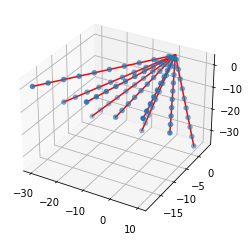

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(positions[...,0], positions[...,1], positions[...,2]);
for i in range(directions.shape[0]):
    start = ray_ori[i]
    end = ray_ori[i] + directions[i, 0] * 20 * tf.linalg.norm(ray_dir[i])
    ax.plot3D([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], "red")
plt.show()